In [52]:
import pandas as pd
import json
from nltk import ngrams
import re
import numpy as np
import itertools as it
import random
import operator
import matplotlib.pyplot as plt
from collections import defaultdict


In [53]:
#The data file couldn't be checked into github because it is too large instead it must be downloaded here #https://www.dropbox.com/s/ir6he8jxxagugnw/assignment3_aricles.json?dl=0datafile =  'data/assignment3_aricles.json'

In [54]:
articles = pd.read_json('assignment3_aricles.json', orient='records', encoding="utf-8")
list_of_primes = np.array(pd.read_csv('P-1000000.txt', sep=",", header=None))[:,1]

In [55]:
#You can use n-gram at word level for this task
#try with different n-gram values 
# You can use ngrams from nltk for this

def getNgrams(articles,K):
    # Param type_split : the type of splitting is it by word or number of character
    print('Getting Ngrams for all articles')
    Ngrams_lists = []
    n_articles=len(articles)

    for article in articles:
        # convert to lower case
        article = article.lower()
        # Replace all none alphanumeric characters with spaces
        article = re.sub(r'[^a-zA-Z0-9\s]', ' ', article)
        #article = re.sub(r"[^\w\s]", ' ', article)
        article = article.replace('\n',' ')
        words = [word for word in article.split(' ') if word !='']
        length_words = len(words)
        Ngrams_lists.append([' '.join(words[i:i+K]) for i in range(0,length_words) if i+K<=length_words])
        
    #return list of ngrams for each article
    return Ngrams_lists

## Convert n-grams into binary vector representation for each document. You can do some optimzations if the matrix is too big.
For example, 
* Select top 10000 most frequent n-grams.
* You may also try smaller values of n (like 2 or 3) which result in fewer n-grams.
* Finally, you can also try sparse matrix representation. Like csr_matrix from  scipy.sparse.

In [56]:
def getBinaryMatrix(articles_ngram,partial= True):
    #parameter 
    #partial = True -> select top 10000 shingles, False -> all shingles
    
    shingles_id = {}
    shingles_count = {}
    binary_matrix2 = {}
    
    print('Creating shingles_id and binary matrix')
    for i in range(len(articles_ngram)):
        for j in range(len(articles_ngram[i])):
            shingle = articles_ngram[i][j]
            if len(shingles_id)==0:
                shingles_id[shingle] = 0
                binary_matrix2[0] = [i]
                shingles_count[0] = 1
            elif shingle in shingles_id:
                shing_id = shingles_id[shingle]
                shingles_count[shing_id] = shingles_count[shing_id]+1
                if i not in binary_matrix2[shing_id]:
                    binary_matrix2[shing_id].append(i)
            else:
                new_id = len(shingles_id)
                shingles_id[shingle] = new_id
                binary_matrix2[new_id] = [i]
                shingles_count[new_id] = 1
    
    #Run if partial == true
    if partial==True:
        n_top = 10000
        print('sorting shingles based on frequency and get the top 10000')
        sorted_shingles = sorted(shingles_count.items(),key=operator.itemgetter(1),reverse=True)[:n_top]
        print('Creating subset binary matrix')
        bin_matrix_subset = {}
        shingles_id_subset = {}
        
        shingles_list = list(shingles_id.keys())
        for i in range(n_top):
            s_id = sorted_shingles[i][0]
            bin_matrix_subset[i] = binary_matrix2[s_id]
            
            shingles_id_subset[shingles_list[s_id]] = i
        
        #bin_matrix_subset = {key:binary_matrix2[key] for key in top_n_shingles}
        return bin_matrix_subset,shingles_id_subset
    
    #Run if partial == False    
    else:
        return binary_matrix2,shingles_id
            


## We need hash function that maps integers 0, 1, . . . , k − 1 to bucket numbers 0 through k − 1. It might be impossible to avoid collisions but as long as the collions are too many it won't matter much.

* The simplest would be using the builtin hash() function, it can be for example, hash(rownumber) % Numberofbuckets
* You can generate several of these hash functions by xoring a random integer (hash(rownumber)^randint) % Numberofbuckets
* It can also be a as simple as (rownumber * randint) % Numberofbuckets

Random Hash Eq
The coefficients a and b are randomly chosen integers less than the maximum value of x. c is a prime number slightly bigger than the maximum value of x.

In [57]:
def get_next_prime(number):
    return list_of_primes[list_of_primes>number][0]

def getHashFunctionValues(numrows, numhashfunctions=200):
    #return a matrix with hash values
    print('getting hash values')
    hashvalues = []
    
    #using universal hash function ax+b mod c
    #a is any odd number between 1 to next_prime-1(inclusive)
    #b is any number between 0 to next_prime -1 (inclusive)
    #c is maximum possible value for the hash code + 1
    #next_prime is prime number that is greater than max possible value of x 
    
    next_prime = get_next_prime(numrows-1)
    print('prime number is=',next_prime)
    a = np.array(random.choices(range(1,next_prime,2),k=numhashfunctions))
    b = np.array(random.sample(list(range(0,next_prime)),numhashfunctions))
    c = np.array(np.ones((numhashfunctions,))*numrows)
    
    print('constructing hash value matrix')
    
    for i in range(numrows):
        hashvalues.append(((a*i + b)% c).astype(int))
        
    return np.array(hashvalues).reshape(numrows,numhashfunctions)
    

## Compute minhash following the faster algorithm from the lecture 

In [58]:
def getMinHashSignatureMatrix(binary_matrix, hash_val_matrix,n_doc):
    #return minhash signature matrix
    print('Creating Signature Matrix...')
    minhash_signature = np.array(np.ones((hash_val_matrix.shape[1],n_doc)) * np.inf)

    for key in binary_matrix:
        for index in binary_matrix[key]:
            minhash_signature[:,index] = np.minimum(minhash_signature[:,index],hash_val_matrix[key])
    
    #replace the infinity to max values in the matrix +1 just to avoid problem in the mathematic steps further
    #minhash_signature[minhash_signature == np.inf] = minhash_signature[minhash_signature!=np.inf].max()+1
    
    return minhash_signature

## Hash signature bands into buckets. Find a way to combine all the signature values in a band and hash them into a number of buckets ususally very high.
* Easiest way is to add all the signature values in the bucket and use a similar hash function like before

In [59]:
def getLSH(signature_matrix, num_bands, num_buckets): #removing hashfunctions from the parameter 
    #return lsh buckets or hash table
    print('Hashing into buckets...')
    buckets = {}
    
    r = int(signature_matrix.shape[0]/num_bands)
    n_doc = signature_matrix.shape[1]
    
    #using hash() from Python
    for i in range(num_bands):
        each_band = signature_matrix[i*r:(i*r)+r]
        for j in range(n_doc):
            hash_value = hash(tuple(each_band[:,j]))
            if hash_value in buckets:
                buckets[hash_value].append(j)
            else:
                buckets[hash_value]= [j]
    print('Done Hashing')
    return buckets

## Tune parameters to make sure the threshold is appropriate.
## plot the probability of two similar items falling in same bucket for different threshold values


Best parameters will be : n_hash= 200 ,n_bands = 20, n_rows = 10
With threshold =  0.7411344491069477


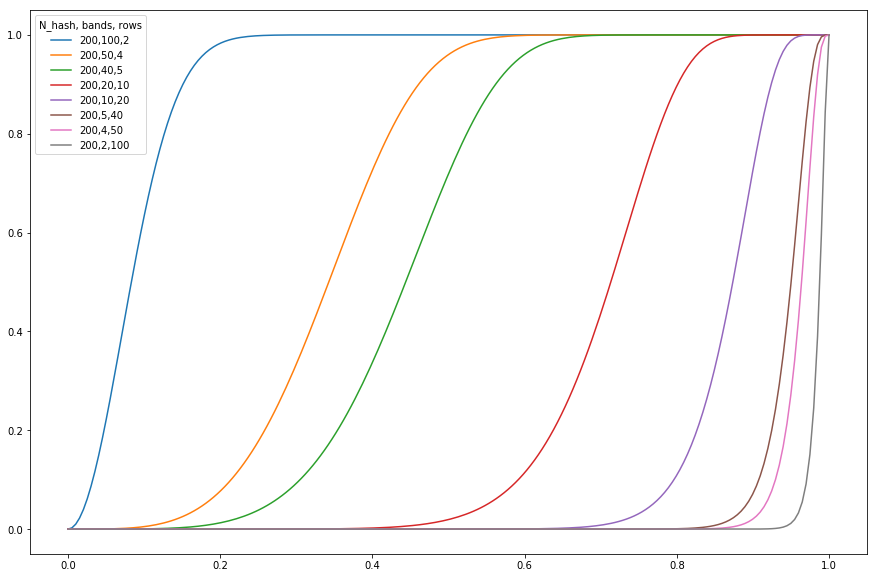

In [60]:
def get_prob(s,b,r):
    prob = 1-(1-s**r)**b
    return prob

#pairs of number of bands and rows
parameters = [[100,2],[50,4],[40,5],[20,10],[10,20],[5,40],[4,50],[2,100]]
n_hash = 200
prob = []

s = np.linspace(0,1,200)
for parameter in parameters:
    prob.append(get_prob(s,parameter[0],parameter[1]))

#Plotting each stock dataset in the list
plot_color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)

for j in range(len(prob)):
    ax.plot(s, prob[j], label=str(n_hash)+','+str(parameters[j][0])+','+str(parameters[j][1]))
ax.legend(loc='best',title="N_hash, bands, rows")
    
print ('Best parameters will be : n_hash=',n_hash,',n_bands = 20, n_rows = 10')
print('With threshold = ', (1/20)**(1/10))


In [61]:
#Parameters to tune
n_bands =20
n_rows =10
n_hash = n_bands*n_rows
num_buckets = 2000000
K = 3 #for the ngrams

# Get all the n_grams for each articles
articles_ngram = getNgrams(articles.iloc[:,0].to_list(),K)

#construct binary_matrix (using new function),
#if partial is True, then it will take 10000 top occuring shingles, if partial is False, then all shingles will be selected
binary_matrix,shingles_id = getBinaryMatrix(articles_ngram,partial=True)
nrow = len(binary_matrix)

#construct binary_matrix
#binary_matrix,nrow = getBinaryMatrix(articles_ngram)
hash_values = getHashFunctionValues(nrow,n_hash)

signature_matrix = getMinHashSignatureMatrix(binary_matrix,hash_values,articles.shape[0])
buckets = getLSH(signature_matrix,n_bands,num_buckets)
print('done')

Getting Ngrams for all articles
Creating shingles_id and binary matrix
sorting shingles based on frequency and get the top 10000
Creating subset binary matrix
getting hash values
prime number is= 10007
constructing hash value matrix
Creating Signature Matrix...
Hashing into buckets...
Done Hashing
done


## Choose the best parameters and get nearest neighbors of each articles

In [62]:
from itertools import combinations
from operator import itemgetter

def get_nearest_neighbour(num_doc,buckets,binary_matrix,threshold):
    print('combining pairs..')
    pairs_combinations = []
    for key in buckets.keys():
        if len(buckets[key])>1:
            unique = set(buckets[key])
            if len(unique)>1:
                pairs= list(combinations(unique,2))
                pairs_combinations.append(pairs)
    
    print('get all possible pairs')
    all_possible_pairs = [x for pairs in pairs_combinations for x in pairs]
    
    print('Getting sorted unique pairs')
    unique_possible_pairs = set(all_possible_pairs)
    sorted_unique_pairs = sorted(unique_possible_pairs,key=itemgetter(0))
    
    print('Create Sparse matrix')
    binary_sparse= np.zeros((len(binary_matrix),num_doc)).astype(int)
    
    for key in binary_matrix.keys():
        for item in binary_matrix[key]:
            binary_sparse[key][item] = 1

    
    print('counting jaccard similarity')
    nearest_neighbour = []
    for pair in sorted_unique_pairs:
        c1 = binary_sparse[:,pair[0]]
        c2 = binary_sparse[:,pair[1]]
        similarity = sum(c1&c2)/sum(c1|c2)
        #print('similarity = ', similarity)
        if similarity>= threshold:
            nearest_neighbour.append(pair)
    
    return nearest_neighbour


def get_nearest_neighbour2(num_doc,buckets,binary_matrix,threshold):
    print('Create Sparse matrix..')
    binary_sparse= np.zeros((len(binary_matrix),num_doc)).astype(int)
    print('Shape of binary_sparse matrix =',binary_sparse.shape)
    
    for key in binary_matrix.keys():
        for item in binary_matrix[key]:
            binary_sparse[key][item] = 1
    
    print('Get unique set of each bucket..')
    buckets_unique = {k: list(np.unique(v)) for (k,v) in buckets.items()}
    
    print('Finding Nearest Neighbour..')
    nearest_neighbour = []
    
    for key in buckets_unique.keys():
        unique_list = buckets_unique[key]
        n = len(unique_list)
        if n>1:
            for i in range (n-1):
                for j in range(i+1,n):
                    c1 = binary_sparse[:,unique_list[i]]
                    c2 = binary_sparse[:,unique_list[j]]
                    similarity = sum(c1&c2)/sum(c1|c2)
                    if similarity>=threshold:
                        nearest_neighbour.append([unique_list[i],unique_list[j]])
    return nearest_neighbour

        
        
        

In [63]:
nearest_neighbour = get_nearest_neighbour(articles.shape[0],buckets,binary_matrix,threshold=0.74)
print('done')

combining pairs..
get all possible pairs
Getting sorted unique pairs
Create Sparse matrix
counting jaccard similarity


/Users/renny/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in long_scalars


done


In [68]:
nearest_neighbour

[(4, 9284),
 (4, 13457),
 (4, 14421),
 (4, 35255),
 (4, 25049),
 (4, 44552),
 (4, 41239),
 (4, 38534),
 (4, 34930),
 (4, 37804),
 (4, 10196),
 (4, 30591),
 (4, 36264),
 (5, 14699),
 (5, 28190),
 (5, 48117),
 (5, 36335),
 (5, 30071),
 (9, 48302),
 (9, 47418),
 (9, 45244),
 (9, 825),
 (9, 38358),
 (9, 34617),
 (9, 26805),
 (9, 33549),
 (9, 44658),
 (9, 21465),
 (9, 20155),
 (12, 6815),
 (12, 34457),
 (12, 10050),
 (12, 29271),
 (12, 24916),
 (12, 23972),
 (12, 45937),
 (12, 4833),
 (12, 24984),
 (12, 25213),
 (12, 9978),
 (12, 40992),
 (12, 16301),
 (12, 2041),
 (12, 31332),
 (12, 8584),
 (12, 37864),
 (12, 6060),
 (12, 36555),
 (12, 39809),
 (12, 42050),
 (12, 32493),
 (12, 43958),
 (12, 4402),
 (12, 22163),
 (12, 26791),
 (12, 16847),
 (12, 3308),
 (12, 38124),
 (12, 27412),
 (12, 22386),
 (12, 36248),
 (12, 38357),
 (12, 26339),
 (12, 31594),
 (12, 1870),
 (12, 40061),
 (12, 42415),
 (12, 17311),
 (12, 2508),
 (12, 35945),
 (12, 47992),
 (12, 30187),
 (12, 30897),
 (12, 47400),
 (12, 

## Write the nearest neibhors of each document to submissions.csv (comma separated, first column is the current document followed by a list of nearest neighbors) file and get the score

In [72]:
import csv
data = ['a,x', 'b,y', 'c,z']
f = open('submissions.csv', 'w')
w = csv.writer(f, delimiter = ',')
w.writerows(nearest_neighbour)
f.close()